In [ ]:
## This code is for testing the Eigen faces under Possion noise:
## The first step is traing the classfier
## Then for the test set, reconstruct one image with Poisson noise 
## Or distinguish it directly

In [ ]:
import os;
from google.colab import drive
drive.mount('/content/drive', force_remount=True);

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

plt.style.use("seaborn-ticks")

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

Mounted at /content/drive


In [ ]:
path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation";

os.chdir(path);

from PMT_compressed_sensing_simu import Compressed_sensing_PMT as CSP;
path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/Eigen Face";
os.chdir(path);



In [ ]:
## convert the dataframe into np.array
df = pd.read_csv('face_data.csv');
X = df.drop('target', axis=1);
X = X.values;
y = df['target'];
y = y.values;

In [ ]:
light_level = 1;
def Eigen_faces(X_train,y_train, X_test, y_test):   

    #X_train, X_test, y_train, y_test = train_test_split(X, y);
    pca = PCA(n_components=105).fit(X_train);
    X_train_pca = pca.transform(X_train);
    classifier = SVC().fit(X_train_pca, y_train);
    X_test_pca = pca.transform(X_test);
    predictions = classifier.predict(X_test_pca);



    return  np.sum(np.array(y_test) == np.array(predictions))/len(y_test);

def img_recons(M, M_inv, X, light_level, Poisson = True, recons = True):
    X = X.T;
    if Poisson:
        X = np.random.poisson(X * light_level) / light_level;
    if recons == False:
        return M.dot(X).T;
    return M_inv.dot(M.dot(X)).T;


1. Raster scan

In [ ]:
index = np.arange(-2,10).astype(float)
light_level_list = np.power(10, index );

Recon_error = [];
Non_recon_error = [];
for light_level in light_level_list: 
    X_train, X_test, y_train, y_test = train_test_split(X, y);
    M = np.eye(64*64)
    M_inv = M;
    ## Recons:
    X_train = img_recons(M,M_inv, X_train, light_level, Poisson = False, recons = True);
    X_test = img_recons(M,M_inv, X_test, light_level, Poisson = True, recons = True);
    Recon_error.append(Eigen_faces(X_train,y_train, X_test, y_test));

    X_train, X_test, y_train, y_test = train_test_split(X, y);
    M = np.eye(64*64)
    M_inv = M;
    ## Recons:
    X_train = img_recons(M,M_inv, X_train, light_level, Poisson = False, recons = False);
    X_test = img_recons(M,M_inv, X_test, light_level, Poisson = True, recons = False);
    Non_recon_error.append(Eigen_faces(X_train,y_train, X_test, y_test))

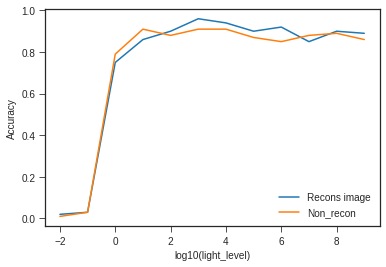

In [ ]:
plt.figure(facecolor = "white");
plt.plot(index, Recon_error, label = 'Recons image');
plt.plot(index, Non_recon_error, label = 'Non_recon');
plt.xlabel('log10(light_level)');
plt.ylabel('Accuracy');
plt.legend();
plt.show();

2. Random Basis

In [ ]:
M = np.round(np.random.random((64*64, 64*64)));
M_inv = np.linalg.pinv(M);

In [ ]:
Recon_error = [];
Non_recon_error = [];
for light_level in light_level_list: 
    X_train, X_test, y_train, y_test = train_test_split(X, y);
    ## with noise
    ## Recons:
    X_train = img_recons(M,M_inv, X_train, light_level, Poisson = False, recons = True);
    X_test = img_recons(M,M_inv, X_test, light_level, Poisson = True, recons = True);
    Recon_error.append(Eigen_faces(X_train,y_train, X_test, y_test));

    ## no Recons:
    X_train, X_test, y_train, y_test = train_test_split(X, y);
    X_train = img_recons(M, M_inv, X_train, light_level, Poisson = False, recons = False);
    X_test = img_recons(M, M_inv, X_test, light_level, Poisson = True, recons = False);
    Non_recon_error.append(Eigen_faces(X_train,y_train, X_test, y_test))

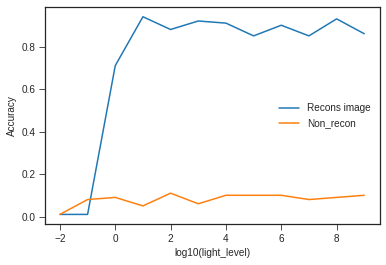

In [ ]:
plt.figure(facecolor = "white");
plt.plot(index, Recon_error, label = 'Recons image');
plt.plot(index, Non_recon_error, label = 'Non_recon');
plt.xlabel('log10(light_level)');
plt.ylabel('Accuracy');
plt.legend();
plt.show();

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y);
## without noise
## Recons:
X_train = img_recons(M,M_inv, X_train, light_level, Poisson = False, recons = True);
X_test = img_recons(M,M_inv, X_test, light_level, Poisson = False, recons = True);
Eigen_faces(X_train,y_train, X_test, y_test)

0.84

In [ ]:
## no Recons:
X_train, X_test, y_train, y_test = train_test_split(X, y);
X_train = img_recons(M, M_inv, X_train, light_level, Poisson = False, recons = False);
X_test = img_recons(M, M_inv, X_test, light_level, Poisson = False, recons = False);
Eigen_faces(X_train,y_train, X_test, y_test)

0.11

3. DCT basis

In [ ]:
pmt = CSP();
M = np.ceil(np.sign(pmt.DCT_Matrix(64**2))/2);
M_inv = np.linalg.pinv(M);


In [ ]:
Recon_error = [];
Non_recon_error = [];
for light_level in light_level_list: 

    X_train, X_test, y_train, y_test = train_test_split(X, y);

    ## Recons:
    X_train = img_recons(M,M_inv, X_train, light_level, Poisson = False, recons = True);
    X_test = img_recons(M,M_inv, X_test, light_level, Poisson = True, recons = True);
    Recon_error.append(Eigen_faces(X_train,y_train, X_test, y_test));

    ## no recon
    X_train, X_test, y_train, y_test = train_test_split(X, y);
    X_train = img_recons(M, M_inv, X_train, light_level, Poisson = False, recons = False);
    X_test = img_recons(M, M_inv, X_test, light_level, Poisson = True, recons = False);
    Non_recon_error.append(Eigen_faces(X_train,y_train, X_test, y_test))

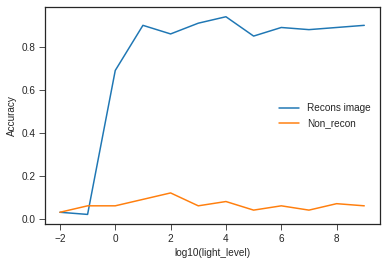

In [ ]:
plt.figure(facecolor = "white");
plt.plot(index, Recon_error, label = 'Recons image');
plt.plot(index, Non_recon_error, label = 'Non_recon');
plt.xlabel('log10(light_level)');
plt.ylabel('Accuracy');
plt.legend();
plt.show();

4. Non 0-1 mask - DCT

In [ ]:
pmt = CSP();
M = (pmt.DCT_Matrix(64**2));
M_inv = pmt.IDCT_Matrix(64**2);

In [ ]:
Recon_error = [];
Non_recon_error = [];
for light_level in light_level_list: 

    X_train, X_test, y_train, y_test = train_test_split(X, y);

    ## Recons:
    X_train = img_recons(M,M_inv, X_train, light_level, Poisson = False, recons = True);
    X_test = img_recons(M,M_inv, X_test, light_level, Poisson = True, recons = True);
    Recon_error.append(Eigen_faces(X_train,y_train, X_test, y_test));

    ## no recon
    X_train, X_test, y_train, y_test = train_test_split(X, y);
    X_train = img_recons(M, M_inv, X_train, light_level, Poisson = False, recons = False);
    X_test = img_recons(M, M_inv, X_test, light_level, Poisson = True, recons = False);
    Non_recon_error.append(Eigen_faces(X_train,y_train, X_test, y_test))

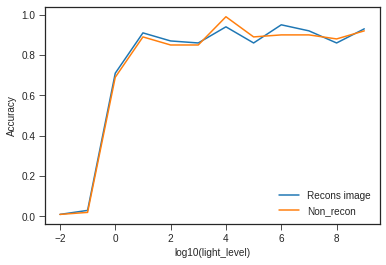

In [ ]:
plt.figure(facecolor = "white");
plt.plot(index, Recon_error, label = 'Recons image');
plt.plot(index, Non_recon_error, label = 'Non_recon');
plt.xlabel('log10(light_level)');
plt.ylabel('Accuracy');
plt.legend();
plt.show();

5. Non 0-1 masks -random

In [ ]:
M = np.random.random((64**2, 64**2));
M_inv = np.linalg.pinv(M);


In [ ]:
Recon_error = [];
Non_recon_error = [];
for light_level in light_level_list: 

    X_train, X_test, y_train, y_test = train_test_split(X, y);

    ## Recons:
    X_train = img_recons(M,M_inv, X_train, light_level, Poisson = False, recons = True);
    X_test = img_recons(M,M_inv, X_test, light_level, Poisson = True, recons = True);
    Recon_error.append(Eigen_faces(X_train,y_train, X_test, y_test));

    ## no recon
    X_train, X_test, y_train, y_test = train_test_split(X, y);
    X_train = img_recons(M, M_inv, X_train, light_level, Poisson = False, recons = False);
    X_test = img_recons(M, M_inv, X_test, light_level, Poisson = True, recons = False);
    Non_recon_error.append(Eigen_faces(X_train,y_train, X_test, y_test));

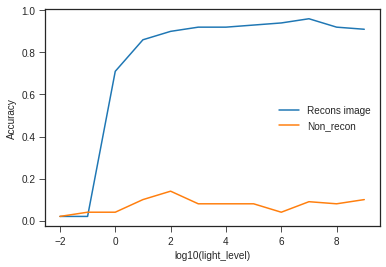

In [ ]:
plt.figure(facecolor = "white");
plt.plot(index, Recon_error, label = 'Recons image');
plt.plot(index, Non_recon_error, label = 'Non_recon');
plt.xlabel('log10(light_level)');
plt.ylabel('Accuracy');
plt.legend();
plt.show();